In [1]:
import sys
import os
import math
import warnings
import torch
import pandas as pd 
import numpy as np
import matplotlib as plt
import seaborn as sns

from transformers import AutoModelForSequenceClassification, AutoTokenizer
from IPython.display import clear_output

In [2]:
torch.cuda.is_available()

True

In [3]:
def list2chunks(a, n):
    k, m = divmod(len(a), n)
    return (a[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n))

class ZeroShotClassifier():
    """
    interface to Zero Shot Topic Classifier
    """

    def __init__(self, model_name='facebook/bart-large-mnli', device=None):
        """
        ZeroShotClassifier constructor
        Args:
          model_name(str): name of a BART NLI model
          device(str): device to use (e.g., 'cuda', 'cpu')
        """
        if 'mnli' not in model_name and 'xnli' not in model_name:
            raise ValueError('ZeroShotClasifier requires an MNLI or XNLI model')
        try:
            import torch
        except ImportError:
            raise Exception('ZeroShotClassifier requires PyTorch to be installed.')
        self.torch_device = device
        if self.torch_device is None: self.torch_device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForSequenceClassification.from_pretrained(model_name).to(self.torch_device)


    def predict(self, docs, labels=[], include_labels=False, multilabel=True,
               max_length=512, batch_size=8, nli_template='This text is about {}.',  topic_strings=[]):
        """
        This method performs zero-shot text classification using Natural Language Inference (NLI).
        Args:
          docs(list|str): text of document or list of texts
          labels(list): a list of strings representing topics of your choice
                        Example:
                          labels=['political science', 'sports', 'science']
          include_labels(bool): If True, will return topic labels along with topic probabilities
          multilabel(bool): If True, labels are considered independent and multiple labels can predicted true for document and be close to 1.
                            If False, scores are normalized such that probabilities sum to 1.
          max_length(int): truncate long documents to this many tokens
          batch_size(int): batch_size to use. default:8
                           Increase this value to speed up predictions - especially
                           if len(topic_strings) is large.
          nli_template(str): labels are inserted into this template for use as hypotheses in natural language inference
          topic_strings(list): alias for labels parameter for backwards compatibility
        Returns:
          inferred probabilities or list of inferred probabilities if doc is list
        """

        # error checks
        is_str_input = False
        if not isinstance(docs, (list, np.ndarray)): 
            docs = [docs]
            is_str_input = True
        if not isinstance(docs[0], str): raise ValueError('docs must be string or a list of strings representing document(s)')
        if len(labels) > 0 and len(topic_strings) > 0: raise ValueError('labels and topic_strings are mutually exclusive')
        if not labels and not topic_strings: raise ValueError('labels must be a list of strings')
        if topic_strings: 
            labels = topic_strings

        # convert to sequences
        sequence_pairs = []
        for premise in docs:
            sequence_pairs.extend([[premise, nli_template.format(label)] for label in labels])
        if batch_size  > len(sequence_pairs): batch_size = len(sequence_pairs)
        if len(sequence_pairs) >= 100 and batch_size==8:
            warnings.warn('TIP: Try increasing batch_size to speedup ZeroShotClassifier predictions')
        num_chunks = math.ceil(len(sequence_pairs)/batch_size)
        sequence_chunks = list2chunks(sequence_pairs, n=num_chunks)

        # inference
        with torch.no_grad():
            outputs = []
            for sequences in sequence_chunks:
                batch = self.tokenizer.batch_encode_plus(sequences, return_tensors='pt', max_length=max_length, truncation='only_first', padding=True).to(self.torch_device)
                logits = self.model(batch['input_ids'], attention_mask=batch['attention_mask'], return_dict=False)[0]
                outputs.extend(logits.cpu().detach().numpy())
                #entail_contradiction_logits = logits[:,[0,2]]

                #probs = entail_contradiction_logits.softmax(dim=1)
                #true_probs = list(probs[:,1].cpu().detach().numpy())
                #result.extend(true_probs)
        outputs = np.array(outputs)
        outputs = outputs.reshape((len(docs), len(labels), -1))

        # process outputs
        # 2020-08-24: modified based on transformers pipeline implementation
        if multilabel:
            # softmax over the entailment vs. contradiction dim for each label independently
            entail_contr_logits = outputs[..., [0, -1]]
            scores = np.exp(entail_contr_logits) / np.exp(entail_contr_logits).sum(-1, keepdims=True)
            scores = scores[..., 1]
        else:
            # softmax the "entailment" logits over all candidate labels
            entail_logits = outputs[..., -1]
            scores = np.exp(entail_logits) / np.exp(entail_logits).sum(-1, keepdims=True)
        scores = scores.tolist()
        if include_labels:
            scores = [list(zip(labels, s)) for s in scores]
        if is_str_input: scores = scores[0]
        return scores

In [4]:
df_orig = pd.read_csv(r'C:\Users\patri\Documents\GitHub\nlp-research\csv\google_scholar.csv')

df = df_orig
df.drop_duplicates(subset='Title', keep='first', inplace=True)
df.reset_index(drop=True, inplace=True)
df

,Index,Title,Citaions,Authors,Conference,Year,Conference Name,Abstract
0,1,Surveylance: Automatically Detecting Online Su...,0,"A Kharraz, W Robertson, E Kirda","39th S&P 2018:\r\nSan Francisco, CA, USA",2018,S&P,Online surveys are a popular mechanism for per...
1,2,EyeTell: Video-Assisted Touchscreen Keystroke ...,2,"Y Chen, T Li, R Zhang, Y Zhanga","39th S&P 2018:\r\nSan Francisco, CA, USA",2018,S&P,Keystroke inference attacks pose an increasing...
2,3,Understanding Linux Malware,4,"E Cozzi, M Graziano, Y Fratantonioa","39th S&P 2018:\r\nSan Francisco, CA, USA",2018,S&P,"For the past two decades, the security communi..."
3,4,SoK: Keylogging Side Channels,1,J Monaco,"39th S&P 2018:\r\nSan Francisco, CA, USA",2018,S&P,The first keylogging side channel attack was d...
4,5,"FuturesMEX: Secure, Distributed Futures Market...",2,"F Massacci, CN Ngo, J Nie, D Venturia","39th S&P 2018:\r\nSan Francisco, CA, USA",2018,S&P,"In a Futures-Exchange, such as the Chicago Mer..."
...,...,...,...,...,...,...,...,...
48606,52298,Evaluation of silicon-on-sapphire enhancement ...,3,"IE Talkhan, HS Abdel",1. Great Lakes Symposium on VLSI 1991:\r\nKala...,1991,ACM Great Lakes Symposium on VLSI,Complete theoretical analysis of SOS n-channel...
48607,52299,Study of quaternary logic versus binary logic,3,"AN Gupte, AK Goel",1. Great Lakes Symposium on VLSI 1991:\r\nKala...,1991,ACM Great Lakes Symposium on VLSI,The authors deal with the comparison of quater...
48608,52300,Design of fail-safe CMOS logic circuits,0,"V Bobin, S Whitaker",1. Great Lakes Symposium on VLSI 1991:\r\nKala...,1991,ACM Great Lakes Symposium on VLSI,Design techniques to make CMOS logic circuits ...
48609,52301,Integrated approach to area-time tradeoff for ...,0,"A Basu, TC Wilson, DK Banerjia",1. Great Lakes Symposium on VLSI 1991:\r\nKala...,1991,ACM Great Lakes Symposium on VLSI,The authors address the issue of area-time tra...


In [5]:
df['Corpus'] = df[['Title', 'Abstract']].apply(lambda x: '. '.join(x), axis = 1)
corpus = df['Corpus']

labels = pd.read_csv(r'C:\Users\patri\Documents\GitHub\nlp-research\csv\conf_labels.csv', header=None)
labels = labels[0].tolist()

In [6]:
zsl = ZeroShotClassifier()

In [7]:
def top_classes(text, labels, titles):
    modeled_topic = zsl.predict(text, labels = labels, include_labels = True, batch_size = 64)
    df_result = pd.DataFrame(modeled_topic, columns = ["Label", "Confidence Score"])
    assigned_label = df_result.sort_values("Confidence Score", ascending = False).head(1)
    assigned_label["Title"] = titles
    assigned_label = assigned_label[["Title", "Label", "Confidence Score"]]
    return assigned_label

def barcount_plot(labels, title):
    ax = labels.value_counts().plot(kind='bar',
                                        figsize=(14,8))
    ax.set_xlabel("Labels")
    ax.set_ylabel("Frequency")

In [8]:
%%time

df_labeled = pd.DataFrame(columns = ["Title", "Label", "Confidence Score"])

for x in range(len(df)):
    #top_title = top_classes(df["Title"][x], labels, df["Title"][x])
    #top_abstract = top_classes(df["Abstract"][x], labels, df["Title"][x])
    top_label = top_classes(df["Corpus"][x], labels, df["Title"][x])

    #results = [top_title, top_abstract, top_corpus]
    #doc_labels = pd.concat(results)
    #top_label = doc_labels[doc_labels["Likelihood"] == doc_labels["Likelihood"].max()]
    df_labeled = df_labeled.append(top_label)

    clear_output(wait=True)
    print(((x/(len(df)-1))*100), "Completed. There are", ((len(df)-1)-x), "samples remaining.")

0.03497222793663855 Completed. There are 48593 samples remaining.


In [9]:
df_labeled.to_csv(r'C:\Users\patri\Documents\GitHub\nlp-research\csv\zsl_labeled_corpus.csv', index = False, header = True)

In [10]:
df_labeled = pd.read_csv(r'C:\Users\patri\Documents\GitHub\nlp-research\csv\zsl_labeled_corpus.csv')

In [11]:
df_labeled

,Title,Label,Confidence Score
0,Surveylance: Automatically Detecting Online Su...,Security Technology And Implementaitons,0.870043
1,EyeTell: Video-Assisted Touchscreen Keystroke ...,Multimedia Systems,0.777252
2,Understanding Linux Malware,Information Security,0.939462
3,SoK: Keylogging Side Channels,Information Security,0.851009
4,"FuturesMEX: Secure, Distributed Futures Market...",Information Security,0.830397
...,...,...,...
48606,Evaluation of silicon-on-sapphire enhancement ...,Smart Energy Systems,0.384856
48607,Study of quaternary logic versus binary logic,High-Performance Computing And Simulations,0.511075
48608,Design of fail-safe CMOS logic circuits,"Circuits, Reliability, And Fault-Tolerance",0.389998
48609,Integrated approach to area-time tradeoff for ...,Very Large-Scale Integration (VLSI),0.599814


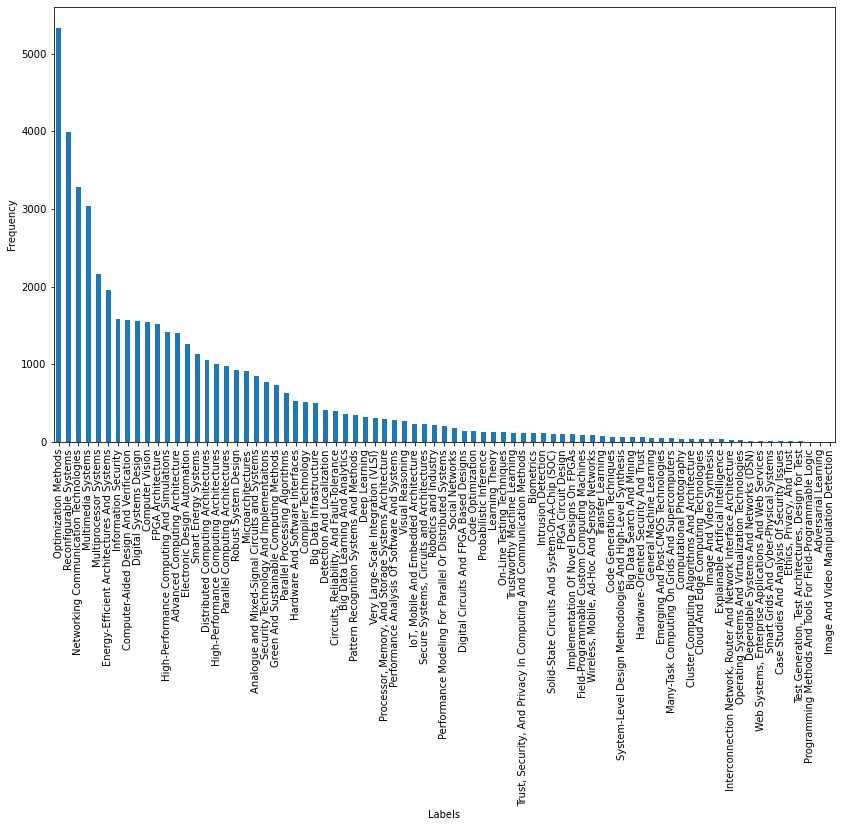

In [12]:
barcount_plot(df_labeled["Label"], "Frequency of Labels with Title Only")

count    48611.000000
mean         0.731829
std          0.211105
min          0.003612
25%          0.607661
50%          0.785519
75%          0.903544
max          0.998633
Name: Confidence Score, dtype: float64


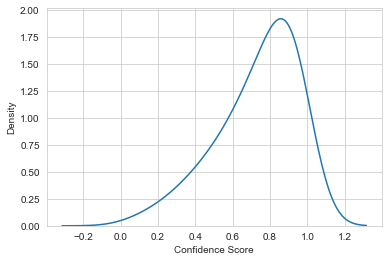

In [13]:
sns.set_style('whitegrid')
sns.kdeplot(df_labeled['Confidence Score'], bw_method=0.5)

print(df_labeled['Confidence Score'].describe())